## Training and deploying a SpatialProp model

This tutorial demonstrates how to train a SpatialProp model from scratch and deploy it for scoring on a coronal mouse tissue brain section. 

We will make use of the `aging_coronal.h5ad` dataset from [Sun et al., 2025](https://www.nature.com/articles/s41586-024-08334-8). This dataset includes coronal brain sections from mice at 20 different ages tiling the entire lifespan. Spatial transcriptomics of 300 genes were profiled with MERFISH technology. To download the dataset, run the following cell:

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
! mkdir -p ./data
! if [ ! -f ./data/aging_coronal.h5ad ]; then \
      echo "Downloading aging_coronal.h5ad..."; \
      wget https://zenodo.org/records/13883177/files/aging_coronal.h5ad -O ./data/aging_coronal.h5ad; \
    else \
      echo "File already exists: ./data/aging_coronal.h5ad — skipping download."; \
  fi

File already exists: ./data/aging_coronal.h5ad — skipping download.


With the `spatial-prop` conda environment activated (see Installation section of [README.md](../README.md)), run the following cell to import the API:

In [41]:
import numpy as np
import scanpy as sc 
import torch

from spatial_gnn.api.perturbation_api import (
    train_perturbation_model,
    create_perturbation_input_matrix,
    predict_perturbation_effects, 
    predict_perturbation_effects
)
from spatial_gnn.utils.plot_utils import plot_loss_curves, plot_celltype_performance

### Define and train the GNN

Training the SpatialProp GNN requires defining the set of training arguments detailed in the [perturbation training API](../src/spatial_gnn/api/perturbation_api.py) docstring. Here we reuse the model configuration reported in the paper. 

Graphs are constructed using 2-hop neighbors centered around cells of all cell types, and we limit to 100 cells per cell type. We augment the training and test sets with 2-hop neighborhood graphs around each surrounding cell. Here we train the base model which does not use or predict cell type labels.

In [39]:
training_args = {
    "dataset": "aging_coronal",
    "exp_name": "api_demo",
    "file_path": "./data/aging_coronal.h5ad",
    "train_ids": ["14"],
    "test_ids": ["11"],
    "k_hop": 2,
    "augment_hop": 2,
    "center_celltypes": "all",
    "node_feature": "expression",
    "inject_feature": "none",
    "learning_rate": 0.0001,
    "loss": "weightedl1",
    "epochs": 30,
    "normalize_total": True,
    "num_cells_per_ct_id": 100,
    "predict_celltype": False,
    "pool": "center",
    "do_eval": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

The training API call will trigger construction of the graph dataset in the `./data/gnn_datasets/` directory.

In [40]:
test_loader, gene_names, (model, model_config, trained_model_path) = train_perturbation_model(
    **training_args,
)

Training new perturbation model from scratch...
Model will be saved to: ./output/api_demo/aging_coronal_expression_2hop_2augment_expression_none/weightedl1_1en04
Training on device: cuda
Dataset already exists at:  ./data/gnn_datasets/aging_coronal_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_all_NoneInject/test
Finished processing test dataset
Dataset already exists at:  ./data/gnn_datasets/aging_coronal_expression_100per_2hop_2C0aug_200delaunay_expressionFeat_all_NoneInject/train
Finished processing train dataset


100%|██████████| 49/49 [00:05<00:00,  8.22it/s]

Train samples: 24879
Test samples: 23628


Expression model initialized on cuda
Starting Baseline training for 30 epochs...
 Epoch: 001, Train WL1: 9.5205, Test WL1: 9.5170, Test Spearman: 0.1380
 Epoch: 002, Train WL1: 8.6376, Test WL1: 8.6523, Test Spearman: 0.3505
 Epoch: 003, Train WL1: 8.0665, Test WL1: 8.0654, Test Spearman: 0.4964
 Epoch: 004, Train WL1: 7.7798, Test WL1: 7.7636, Test Spearman: 0.5317
 Epoch: 005, Train WL1: 7.5708, Test WL1: 7.5478, Test Spearman: 0.5473
 Epoch: 006, Train WL1: 7.4065, Test WL1: 7.3871, Test Spearman: 0.5583
 Epoch: 007, Train WL1: 7.2908, Test WL1: 7.2604, Test Spearman: 0.5658
 Epoch: 008, Train WL1: 7.1740, Test WL1: 7.1487, Test Spearman: 0.5714
 Epoch: 009, Train WL1: 7.0896, Test WL1: 7.0576, Test Spearman: 0.5777
 Epoch: 010, Train WL1: 7.0090, Test WL1: 6.9777, Test Spearman: 0.5795
 Epoch: 011, Train WL1: 6.9417, Test WL1: 6.9071, Test Spearman: 0.5839
 Epoch: 012, Train WL1: 6.8760, Test WL1: 6.8399, Test Spearman: 0.5875
 Epoch: 013, Train WL1: 6.8186, Test WL1: 6.7821, Test 

100%|██████████| 47/47 [00:04<00:00,  9.91it/s]


Computing micro and macro averages...
Finished cell type analysis.
Training completed. Model saved to: output/api_demo/aging_coronal_expression_2hop_2augment_expression_none/weightedl1_1en04/model.pth


### Inference with perturbation model

Define set of perturbations in the form of a dictionary mapping `cell type` → `gene name` → `multiplier`. For instance, entry `'T cell': {'Igf2': 0.0},` indicates knockout of IGF2 in all T-cells in the input dataset.

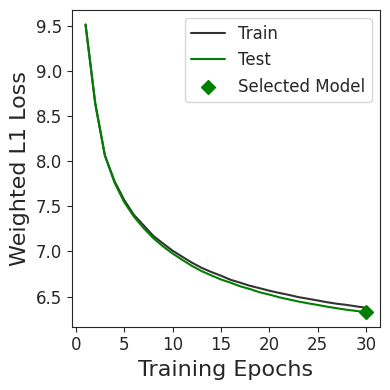

In [44]:
save_dir = "/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/notebooks/output/api_demo/aging_coronal_expression_2hop_2augment_expression_none/weightedl1_1en04"
plot_loss_curves(save_dir)

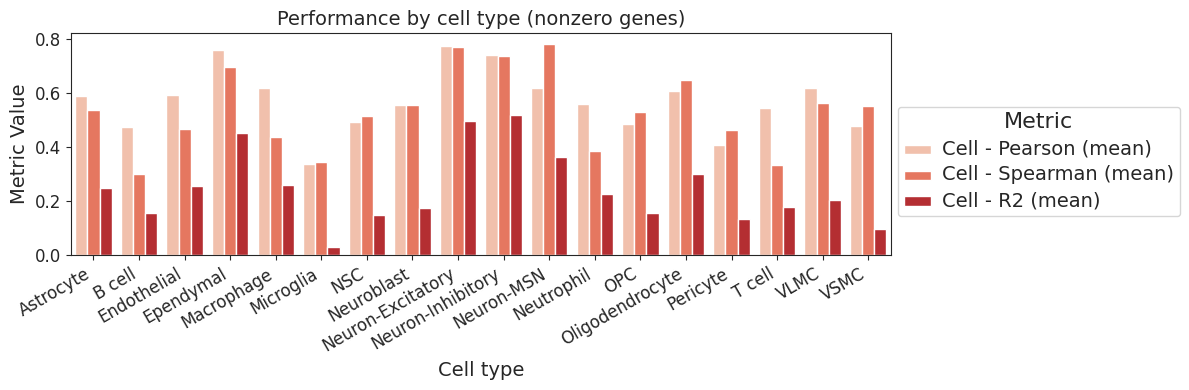

In [45]:
plot_celltype_performance(save_dir)

In [ ]:
# Save perturbation mask to anndata
test_adata = sc.read_h5ad(test_data_path)
test_data_path_perturbed = create_perturbation_mask(test_adata, perturbation_dict, save_path=test_data_path)

In [ ]:
print("\n=== Predicting perturbation effects ===")
adata_perturbed = predict_perturbation_effects(
    adata_path=test_data_path_perturbed,
    model_path=model_path,
    exp_name="aging_sagittal",
    perturbation_dict=perturbation_dict,
    perturbation_mask_key="perturbation_mask"
)

In [3]:
result_path = "/oak/stanford/groups/akundaje/abuen/spatial/spatial-gnn/data/perturbed/aging_coronal_perturbed_result.h5ad"

In [4]:
import scanpy as sc 

adata_result = sc.read_h5ad(result_path)

In [5]:
adata_result

AnnData object with n_obs × n_vars = 1453144 × 300
    obs: 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'transcript_count', 'num_detected_genes', 'barcodeCount', 'mouse_id', 'slide_id', 'cohort', 'age', 'batch', 'celltype', 'region', 'subregion'
    uns: 'neighbors', 'pca', 'perturbation_info', 'umap'
    obsm: 'X_pca', 'X_umap', 'perturbation_mask', 'spatial'
    varm: 'PCs'
    layers: 'perturbation_effects', 'predicted_perturbed'
    obsp: 'connectivities', 'distances'

In [6]:
effects = adata_result.layers['perturbation_effects']